# Distribution of carbon stocks in a protected area

## Overview
The [Global Ecosystem Dynamics Investigation (GEDI) Level 4A Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/2056) dataset provides predictions of the aboveground biomass density (AGBD; in Mg/ha) and estimates of the prediction standard error within each sampled geolocated GEDI footprint. GEDI L4A dataset is available for the period starting 2019-04-17 and covers latitudes of 52 North to 52 South. GEDI L4A data files are natively in HDF5 format.

This tutorial will demonstrate how compute the distribution of carbon stocks or AGBD for a protected area using the GEDI L4A dataset. 

## Learning Objectives
- Use [*earthaccess*](https://nsidc.github.io/earthaccess/) Python library to search for GEDI L4A granules for time and area of interest. The *earthaccess* library simplifies access to NASA's [Common Metadata Repository (CMR) Application Programming Interface (API)](https://cmr.earthdata.nasa.gov/search).
- Use [NASA OPeNDAP Hyrax](https://opendap.earthdata.nasa.gov/) to retrieve the GEDI L4A dataset. Hyrax allows direct access to selected variables for the dataset within the spatial-temporal bounds without having to download the whole data file. 
- Compute distributions of AGBD across various plant functional types (PFTs) in a study area.

## Requirements
### 1. Compute environment
This notebook can be run in any personal computing environment (e.g., desktop/laptops), on-premise solution (e.g., High-Performance Computing), or on the Cloud (e.g., Amazon Web Service).
### 2. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.
### 3. Additional Requirements

This tutorial requires the following Python modules installed in your system: `earthaccess`, `requests`, `netCDF4`, `datetime`, `pandas`, `geopandas`, `contextily`, `shapely`, `seaborn`. To install the necessary Python modules, you can run:
```bash
pip install -r earthaccess requests netCDF4 datetime pandas geopandas contextily shapely seaborn
```

## Import packages

In [1]:
import earthaccess
import pandas as pd
import geopandas as gpd
import contextily as ctx
import netCDF4 as nc
from os import path
from matplotlib import pyplot as plt
from shapely.ops import orient
from IPython import display
from requests.adapters import HTTPAdapter, Retry
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set(style='whitegrid')

Access to NASA OPeNDAP requires NASA Earthdata authentication. We recommend authenticating your [Earthdata Login (EDL)](https://urs.earthdata.nasa.gov) information using the *earthaccess* python libary as follows:

In [2]:
auth = earthaccess.login(strategy="netrc") # works if the EDL login already been persisted to a netrc
if not auth.authenticated:
    # ask for EDL credentials and persist them in a .netrc file
    auth = earthaccess.login(strategy="interactive", persist=True)

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/28/2023
Using .netrc file for EDL



## Search GEDI L4A granules
First, we will search for granules that overlay our area of interest. We will then access the location and science variables for the GEDI shots using OPeNDAP. 

For this tutorial, we will use the boundary of [Annapurna Conservation Area (ACA)](https://en.wikipedia.org/wiki/Annapurna_Conservation_Area), the largest protected area of Nepal, to search for the overlapping GEDI L4A granules. The boundary polygon is stored in a GeoJSON file called [aca.json](https://github.com/ornldaac/gedi_tutorials/blob/main/polygons/aca.json). Let's plot the boundary polygon of the ACA over a basemap.

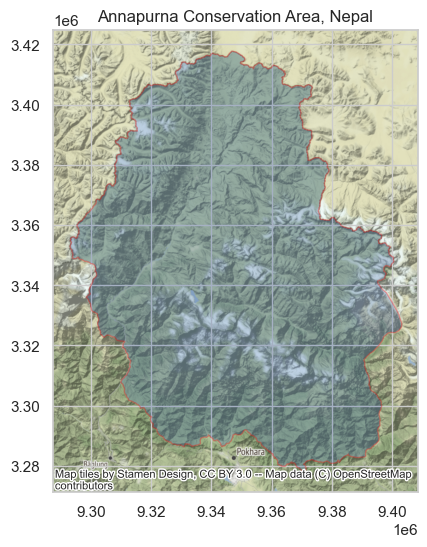

In [3]:
aca = gpd.read_file("https://raw.githubusercontent.com/ornldaac/gedi_tutorials/main/polygons/aca.json") 
ax=aca.to_crs(epsg=3857).plot(figsize=(5, 6), edgecolor="red", alpha=0.3)
ctx.add_basemap(ax)
ax.set_title("Annapurna Conservation Area, Nepal")
plt.show()

We will now search for all the GEDI L4A granules overlapping the ACA boundary polygon using the [Earthaccess](https://nsidc.github.io/earthaccess/) Python library. We will also limit the period of our search to the year 2020 (Jan 1 to Dec 31, 2020). The *earthaccess*'s `search_data` allows searching dataset granules using NASA's [CMR API](https://cmr.earthdata.nasa.gov/search/site/docs/search/api.html). It requires the dataset digital object identifier (DOI), time, and the polygon coordinates as tuples. 

In [4]:
# GEDI L4A DOI 
doi = '10.3334/ORNLDAAC/2056'

# time bound for year 2020
start_date = "2020-01-01" # specify your own start date
end_date = "2020-12-31"  # specify your end start date

# bounding lon, lat as list of tuples
aca.geometry = aca.geometry.apply(orient, args=(1,))
# simplifying the polygon is required to bypass 
# coordinates limit of the CMR, tolerance .005 degrees
xy = aca.geometry.simplify(0.005).get_coordinates()
coord_list = [(x,y) for x,y in zip(xy.x , xy.y)]

granule_arr = earthaccess.search_data(
    count=-1, # needed to retrieve all granules
    doi=doi,
    polygon=coord_list,
    temporal=(start_date, end_date)
)

Granules found: 59


Now, the GEDI L4A granule information, including data URLs, is stored in granule_arr, from which we can create OPeNDAP URLs. We will use NetCDF-4 encoding in the HTTP requests as an NC4 file representation. Let's print the first three granules from the list.

In [5]:
opendap_url = 'https://opendap.earthdata.nasa.gov/collections/C2237824918-ORNL_CLOUD/granules/GEDI_L4A_AGB_Density_V2_1'
opendap_arr = [f'{opendap_url}.{path.basename(granule.data_links()[0])}.dap.nc4' for granule in granule_arr]
total_granules = len(opendap_arr)
# print the first three links
opendap_arr[:3]

['https://opendap.earthdata.nasa.gov/collections/C2237824918-ORNL_CLOUD/granules/GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2020009160947_O06097_02_T00100_02_002_02_V002.h5.dap.nc4',
 'https://opendap.earthdata.nasa.gov/collections/C2237824918-ORNL_CLOUD/granules/GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2020013143447_O06158_02_T04675_02_002_02_V002.h5.dap.nc4',
 'https://opendap.earthdata.nasa.gov/collections/C2237824918-ORNL_CLOUD/granules/GEDI_L4A_AGB_Density_V2_1.GEDI04_A_2020024182123_O06331_03_T00197_02_002_02_V002.h5.dap.nc4']

## Access the variables of interest for the subset area

OPeNDAP allows access to the dataset of interest, so you can only download the variables you are interested in and, by doing so, save the download bandwidth. For this tutorial, we are interested in the following selected science variables  (`agbd`, `l4_quality_flag`, and `pft_class`) for four full-powered beams of the eight GEDI beams. Refer to this [tutorial](https://github.com/ornldaac/gedi_tutorials/blob/main/3_gedi_l4a_exploring_data.ipynb) for more information about GEDI L4A data structure.

In [6]:
# variables of interests
variables = ['agbd', 'l4_quality_flag', 'land_cover_data/pft_class']

# beams of interest
beams = ['BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011']

We will save the data retrieved into the following CSV file.

In [7]:
# output CSV file
out_csv = 'aca_gedi_l4a.csv'

# setting header variables
headers = ['lat_lowestmode', 'lon_lowestmode', 'elev_lowestmode', 'shot_number']
headers.extend(variables)

with open(out_csv, "w") as f:
    f.write(','.join(headers)+'\n')

Now, we will retrieve the dataset from the OPeNDAP Hyrax server.  Let's set up a session and set the number of maximum retries.

In [8]:
# setting up maximum retries for HTTP session to get around Hyrax 500 error
session = earthaccess.get_requests_https_session()
retries = Retry(total=10, backoff_factor=0.1, status_forcelist=[ 500, 502, 503, 504 ])
session.mount('https://', HTTPAdapter(max_retries=retries))

First, we will access the geographic variables (`lat_lowestmode`, `lon_lowestmode`) of all the GEDI shots within the beam to identify the shots overlapping the area of interest. We will then retrieve the science variables of interest (`agbd`, `agbd_t`, etc.) for the area of interest and save it as the CSV file we created above.

The following step will take some time to run as there are 59 granules to process. The figure below will update to indicate the download status.

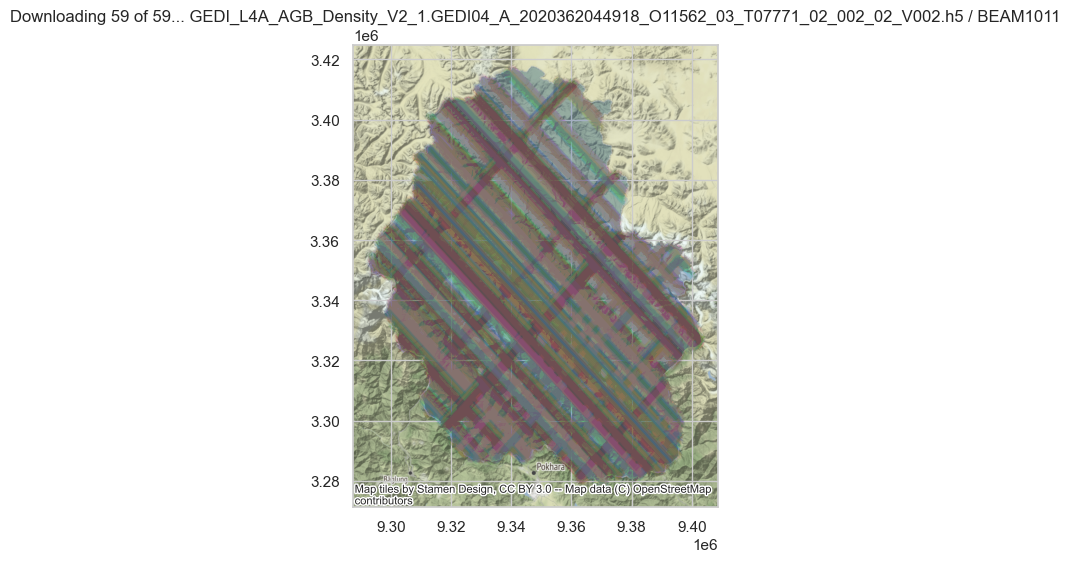

In [9]:
# plotting the area of interest
ax=aca.to_crs(epsg=3857).plot(figsize=(5, 6), alpha=0.3)
ctx.add_basemap(ax)
ax.set_title("Starting download...")
display.display(plt.gcf())
display.clear_output(wait=True)

c=0
for g_name in opendap_arr:
    c += 1
    # loop over all beams
    for beam in beams:       
        # 1. Retrieving lat, lon coordinates for the file
        hyrax_url = f"{g_name}?dap4.ce=/{beam}/lon_lowestmode;/{beam}/lat_lowestmode"
        r = session.get(hyrax_url)
        r.raise_for_status()
        with nc.Dataset('hyrax', memory=r.content) as ds:
            df = pd.DataFrame({'lat_lowestmode': ds[beam]['lat_lowestmode'][:], 
                               'lon_lowestmode': ds[beam]['lon_lowestmode'][:]}) # creating pandas dataframe  

        # 2. Subsetting by bounds of the area of interest
        # converting to geopandas dataframe
        gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode)) 
        gdf_aca = gdf[gdf['geometry'].within(aca.geometry[0])]   
        if not gdf_aca.empty:
            # creating empty columns for variables
            for v in headers[2:]:
                gdf_aca[v] = None
            # 3. retrieving variables of interest, agbd, agbd_t in this case.
            # We are only retriving the shots within subset area.
            for _, df_gr in gdf_aca.groupby((gdf_aca.index.to_series().diff() > 1).cumsum()):
                i = df_gr.index.min()
                j = df_gr.index.max()
                for v in headers[2:]:
                    hyrax_url = f"{g_name}?dap4.ce=/{beam}/{v}%5B{i}:{j}%5D"
                    r = session.get(hyrax_url)
                    r.raise_for_status()
                    with nc.Dataset('hyrax', memory=r.content) as ds:
                        gdf_aca.loc[i:j, (v)] = ds[beam][v][:]

            # saving the output file
            gdf_aca.to_csv(out_csv, mode='a', index=False, header=False, columns=headers)

            # plotting the shots
            gdf_aca.crs = "EPSG:4326"
            gdf_aca.to_crs(epsg=3857).plot(alpha=0.01, ax=ax, linewidth=0)
            ax.set_title(f"Downloading {c} of {total_granules}... {g_name.rsplit('/', 1)[-1][:-8]} / {beam}")
            display.display(plt.gcf())
            display.clear_output(wait=True)

We have saved the subset data for the GEDI shots within the ACA boundary to the file `aca_gedi_l4a.csv`. Let's open the CSV file and print the first few rows.

In [10]:
# reading the csv file created in the last step
l4a_df = pd.read_csv(out_csv)
l4a_df.head()

,lat_lowestmode,lon_lowestmode,elev_lowestmode,shot_number,agbd,l4_quality_flag,land_cover_data/pft_class
0,28.533718,83.651917,1334.218384,60970500200160455,2.014405,0,6
1,28.534097,83.652311,1336.080078,60970500200160456,63.936985,0,4
2,28.534474,83.652703,1344.832642,60970500200160457,18.221430,0,4
3,28.534852,83.653096,1349.221069,60970500200160458,76.016953,0,4
4,28.535227,83.653488,1362.543945,60970500200160459,23.200373,0,4


## Distribution of AGBD in Annapurna Conservation Area
The `pft_class` variable provides the plant functional types for the shots derived from the MODIS land cover type product ([MCD12Q1](https://doi.org/10.5067/MODIS/MCD12Q1.006)). It uses LC_Type5 or Annual PFT classification. We can now plot the distribution of the AGBD by plant functional types (PFTs) for the good-quality shots in the ACA region. 

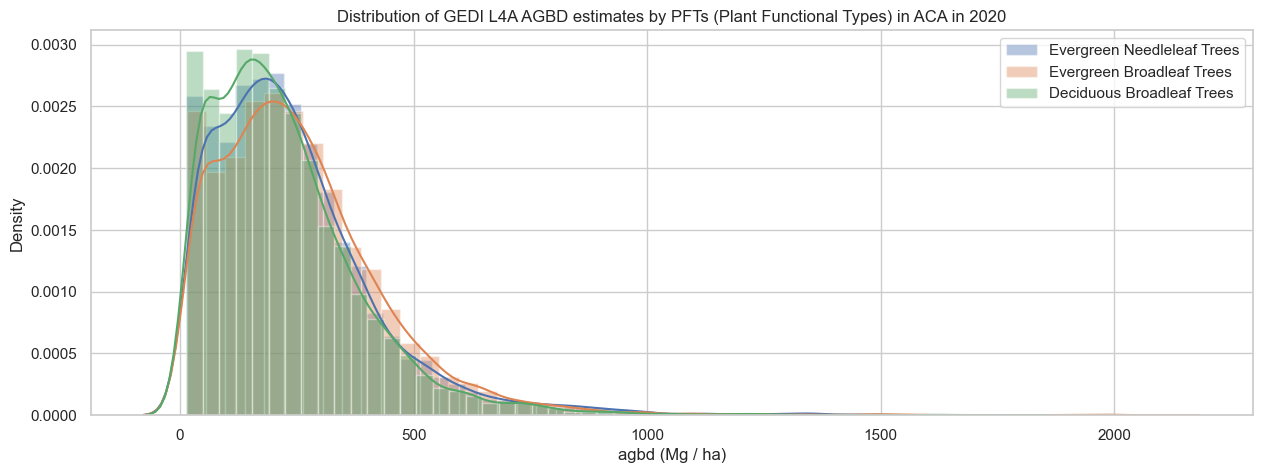

In [11]:
# MCD12Q1 PFT types
pft_legend = {0 : 'Water Bodies', 1: 'Evergreen Needleleaf Trees', 2: 'Evergreen Broadleaf Trees', 
              3: 'Deciduous Needleleaf Trees',  4: 'Deciduous Broadleaf Trees', 5: 'Shrub', 6: 'Grass',
              7: 'Cereal Croplands', 8: 'Broadleaf Croplands', 9: 'Urban and Built-up Lands', 
              10: 'Permanent Snow and Ice', 11: 'Barren', 255: 'Unclassified'}

# creating mask with good quality shots and trees/shrubs pft class
mask = (l4a_df['l4_quality_flag']==1) & (l4a_df['land_cover_data/pft_class'] <= 5 ) 
plt.figure(figsize=(15,5))
ax = l4a_df[mask].groupby('land_cover_data/pft_class')['agbd'].\
            apply(lambda x: sns.distplot(x, label = pft_legend[x.name], hist=True))
plt.xlabel('agbd (Mg / ha)')
plt.title('Distribution of GEDI L4A AGBD estimates by PFTs (Plant Functional Types) in ACA in 2020')
plt.legend()
plt.show()

Let's plot how the AGBD is distributed across elevation ranges for different PFTs.

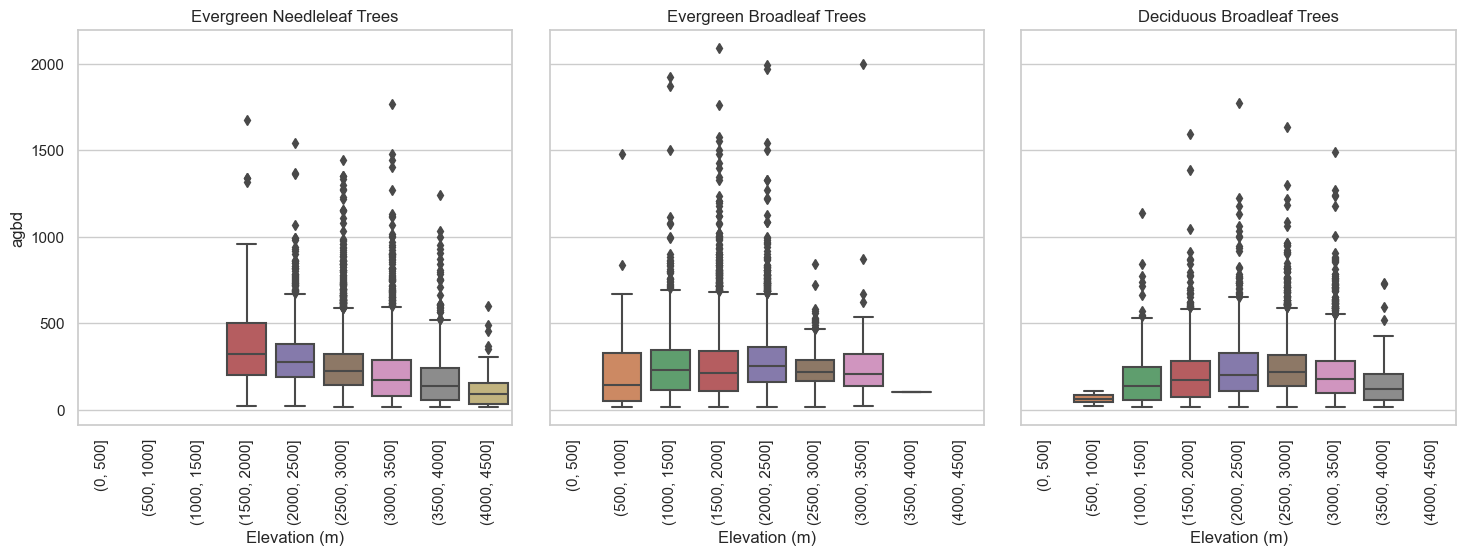

In [12]:
l4a_df['elev_bin']=pd.cut(l4a_df['elev_lowestmode'], bins =range(0, 5000, 500))
g = sns.catplot(x = "elev_bin", y = "agbd", data = l4a_df[mask], col="land_cover_data/pft_class", kind="box")
g.set_xticklabels(rotation=90)
g.set_titles("{col_name}")
for ax in g.axes.flat:
    ax.set_title(pft_legend[int(float(ax.get_title()))])
g.set_axis_labels("Elevation (m)")
sns.despine(top=False, right=False, left=False, bottom=False, offset=None, trim=False)
plt.show()

Additional tutorials on discovering, accessing, and using GEDI Level 3 and Level 4 data products are available at https://github.com/ornldaac/gedi_tutorials.